In [1]:
import numpy as np
import scipy

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
    
from datetime import datetime
import time

In [2]:
class OrthogonalCollocations:
    
    def __init__(self, V_0, R, M):
        self.V_0 = V_0
        self.R = R
        self.M = M
        
        # grid points
        self.x = np.linspace(-R, R, M+1)
        self.delta = self.x[1] - self.x[0]
        
        # collocation points
        self.x_c = np.zeros(2*self.M)
        self.x_c[::2] = self.x[:-1] + self.delta/2 * (1 - 1/np.sqrt(3))
        self.x_c[1::2] = self.x[:-1] + self.delta/2 * (1 + 1/np.sqrt(3))
        
    
    def V(self, x):
        return self.V_0 * np.exp(-x**2)
    
    
    # functions in S_{3,2}
    def phi(self, k, x_):
        if x_ > self.x[k] - self.delta and x_ <= self.x[k]:
            return -2/self.delta**3 * (x_-self.x[k])**3 - 3/self.delta**2 * (x_-self.x[k])**2 + 1
        elif x_ > self.x[k] and x_ <= self.x[k] + self.delta:
            return 2/self.delta**3 * (x_-self.x[k])**3 - 3/self.delta**2 * (x_-self.x[k])**2 + 1
        else:
            return 0.0
        
    def psi(self, k, x_):
        if x_ > self.x[k] - self.delta and x_ <= self.x[k]:
            return 1/self.delta**2 * (x_-self.x[k])**3 + 2/self.delta * (x_-self.x[k])**2 + (x_-self.x[k])
        elif x_ > self.x[k] and x_ <= self.x[k] + self.delta:
            return 1/self.delta**2 * (x_-self.x[k])**3 - 2/self.delta * (x_-self.x[k])**2 + (x_-self.x[k])
        else:
            return 0.0
    
    
    # second derivatives of these functions
    def phi_xx(self, k, x_):
        if x_ > self.x[k] - self.delta and x_ <= self.x[k]:
            return -12/self.delta**3 * (x_-self.x[k]) - 6/self.delta**2
        elif x_ > self.x[k] and x_ <= self.x[k] + self.delta:
            return 12/self.delta**3 * (x_-self.x[k]) - 6/self.delta**2
        else:
            return 0.0

        
    def psi_xx(self, k, x_):
        if x_ > self.x[k] - self.delta and x_ <= self.x[k]:
            return 6/self.delta**2 * (x_-self.x[k]) + 4/self.delta
        elif x_ > self.x[k] and x_ <= self.x[k] + self.delta:
            return 6/self.delta**2 * (x_-self.x[k]) - 4/self.delta
        else:
            return 0.0


    # functions that form something like basis in S_{3,2}
    def S(self, l, x_):
        if l == 0 or l == 2*self.M:
            return self.psi(l//2, x_)
        elif l % 2 == 1:
            return self.psi((l+1)//2, x_)
        else:
            return self.phi(l//2, x_)

        
    # and their second derivatives
    def S_xx(self, l, x_):
        if l == 0 or l == 2*self.M:
            return self.psi_xx(l//2, x_)
        elif l % 2 == 1:
            return self.psi_xx((l+1)//2, x_)
        else:
            return self.phi_xx(l//2, x_)
    
    
    def eigvals(self):
        A = np.zeros((2*self.M, 2*self.M))
        B = np.zeros((2*self.M, 2*self.M))

        for l in range(2*self.M):
            for t in range(2*self.M):
                A[l,t] = -self.S_xx(l, self.x_c[t]) + self.V(self.x_c[t]) * self.S(l, self.x_c[t])
                B[l,t] = self.S(l, self.x_c[t]) 

        Mat = scipy.linalg.inv(B) @ A
        
        eigvals = np.sort(scipy.linalg.eigvals(Mat))
        
        return eigvals[(eigvals<0.0)*(eigvals>self.V_0)]
    
    def fast_eigvals(self):
        A = np.zeros((2*self.M, 2*self.M))
        B = np.zeros((2*self.M, 2*self.M))

        for l in range(2*self.M):
            for t in range(2*self.M):
                A[l,t] = -self.S_xx(l, self.x_c[t]) + self.V(self.x_c[t]) * self.S(l, self.x_c[t])
                B[l,t] = self.S(l, self.x_c[t]) 
                
        w = scipy.sparse.linalg.eigs(A, k=6, M=B, sigma=self.V_0, return_eigenvectors=False)
        
        return w[(w>self.V_0)*(w<0.0)]       

# Task 1

In [3]:
n = np.zeros(100)
v0 = np.linspace(-20.0+1e-2, -1e-2, len(n))

for i in range(len(n)):
    oc = OrthogonalCollocations(v0[i], 20, 300)
    n[i] = len(oc.fast_eigvals())
#     n[i] = len(oc.eigvals())
    if i % 5 == 0: print(i)

0
5
10
15
20
25
30
35
40
45


KeyboardInterrupt: 

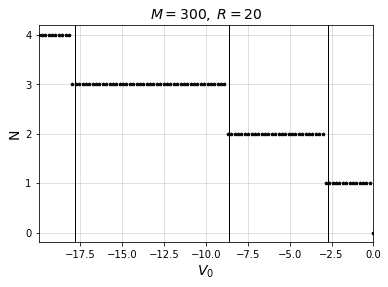

In [9]:
plt.plot(v0, n, linestyle='', marker='p', color='black', ms=3)
plt.axvline(x=-2.684, color='black', linestyle='-', linewidth=1)
plt.axvline(x=-8.650, color='black', linestyle='-', linewidth=1)
plt.axvline(x=-17.796, color='black', linestyle='-', linewidth=1)

plt.xlabel(r'$V_0$', fontsize=14)
plt.ylabel('N', fontsize=14)

plt.title(r'$M=300,\; R=20$', fontsize=14)

plt.yticks([0,1,2,3,4])
plt.xlim(v0[0], 0)

plt.grid(alpha=0.5)

plt.savefig('figures/num_eigen_vs_v0.pdf')

# Task 2

In [25]:
m = np.linspace(10, 1000, dtype=int)
t = [None] * len(m)

print('m   t')

for i in range(len(m)):
    start_time = datetime.now()
    
    oc = OrthogonalCollocations(-1, 20, m[i])
    eigvals = oc.fast_eigvals()
#     eigvals = oc.eigvals()
    
    t[i] = datetime.now() - start_time
    
    print(m[i],t[i])
    

m= 10 , t= 0:00:00.074147
m= 30 , t= 0:00:00.043584
m= 50 , t= 0:00:00.099850
m= 70 , t= 0:00:00.295730
m= 90 , t= 0:00:00.357650
m= 111 , t= 0:00:01.781281
m= 131 , t= 0:00:00.602604
m= 151 , t= 0:00:00.784873
m= 171 , t= 0:00:01.071690
m= 191 , t= 0:00:01.359252
m= 212 , t= 0:00:01.687975
m= 232 , t= 0:00:01.854537
m= 252 , t= 0:00:01.985119
m= 272 , t= 0:00:02.362053
m= 292 , t= 0:00:03.449430
m= 313 , t= 0:00:03.485451
m= 333 , t= 0:00:03.674254
m= 353 , t= 0:00:04.305354
m= 373 , t= 0:00:04.860402
m= 393 , t= 0:00:04.851834
m= 414 , t= 0:00:05.245998
m= 434 , t= 0:00:05.715154
m= 454 , t= 0:00:06.269247
m= 474 , t= 0:00:06.652322
m= 494 , t= 0:00:07.248607
m= 515 , t= 0:00:07.965362
m= 535 , t= 0:00:08.684563
m= 555 , t= 0:00:09.127054
m= 575 , t= 0:00:11.214614
m= 595 , t= 0:00:11.095860
m= 616 , t= 0:00:11.905875
m= 636 , t= 0:00:13.040743
m= 656 , t= 0:00:13.060873
m= 676 , t= 0:00:13.525056
m= 696 , t= 0:00:14.411787
m= 717 , t= 0:00:15.098551
m= 737 , t= 0:00:16.199942
m= 757

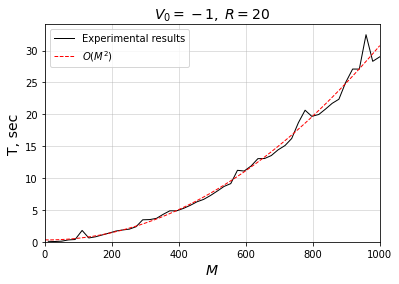

In [28]:
tt = [t_.seconds+t_.microseconds*1e-6 for t_ in t]

p = np.poly1d(np.polyfit(m, tt, 2))
mm = np.linspace(0, m[-1])

plt.plot(m, tt, color='black', linewidth=1, label='Experimental results')

plt.plot(mm, p(mm), color='red', linewidth=1, linestyle='--', label=r'$O(M^2)$')

plt.xlabel(r'$M$', fontsize=14)
plt.ylabel('T, sec', fontsize=14)

plt.title(r'$V_0=-1,\; R=20$', fontsize=14)

plt.xlim(0, m[-1])
plt.ylim(0, None)

plt.grid(alpha=0.5)
plt.legend()

plt.savefig('figures/T_vs_M.pdf', bbox_inches='tight')

# Task 3

In [20]:
e0 = np.full((10,10), np.nan)
r = np.linspace(4,20, 10)
m = np.linspace(10, 500, 10, dtype=int)

# e_0_true = -0.3539907385825565

for i in range(10):
    for j in range(10):
        oc = OrthogonalCollocations(-1, r[i], m[j])
        eigvals = oc.fast_eigvals()
        if len(eigvals) > 0:
            e0[i,j] = eigvals[0].real
        print(i,j)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
4 0


/home/mrk/.local/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:857: RuntimeWarning: divide by zero encountered in divide
  rd = 1 / (d - self.sigma)
/home/mrk/.local/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:857: RuntimeWarning: invalid value encountered in divide
  rd = 1 / (d - self.sigma)


4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9


In [24]:
e0_pres = np.zeros(len(e0))
for i in range(len(e0)):
    p = np.poly1d(np.polyfit(1/m[~np.isnan(e0[i,:])], abs(e0[i,~np.isnan(e0[i,:])]), 2))
    e0_pres[i] = -p(0.0)

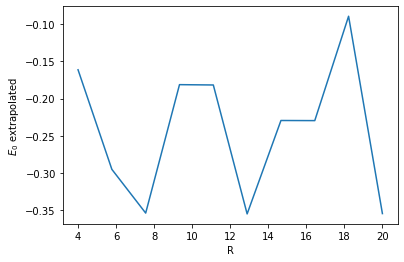

In [25]:
plt.plot(r, e0_pres)
plt.xlabel('R')
plt.ylabel(r'$E_0$ extrapolated')
plt.savefig('figures/E0_extrapolated.pdf', bbox_inches='tight')

In [26]:
z = np.abs([e0[i,:]-e0_pres[i] for i in range(len(e0))])
z[z==0] = np.nan

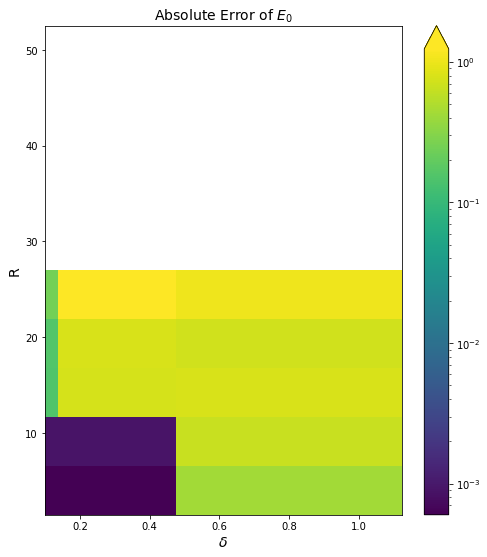

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8,9))

pcm = ax.pcolormesh(2*r/m, r, z,
                    norm=colors.LogNorm(vmin=np.nanmin(z),
                                        vmax=np.nanmax(z)),
                    )

fig.colorbar(pcm, ax=ax, extend='max')

ax.set_xlabel(r'$\delta$', fontsize=14)
ax.set_ylabel('R', fontsize=14)

ax.set_title(r'Absolute Error of $E_0$', fontsize=14)

fig.savefig('figures/abserr.pdf')

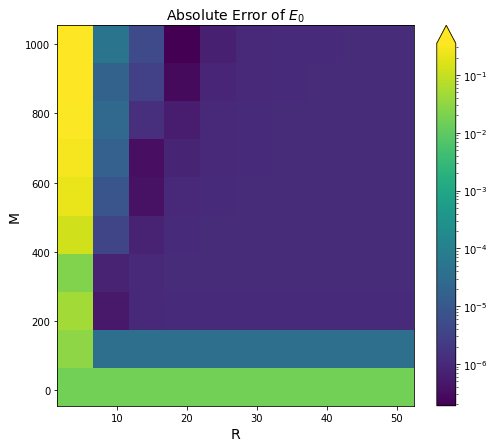

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(8,7))

pcm = ax.pcolormesh(r, m, np.abs(err), norm=colors.LogNorm(vmin=np.abs(err).min(),
                                                          vmax=np.abs(err).max()),
                    )
fig.colorbar(pcm, ax=ax, extend='max')

ax.set_xlabel('R', fontsize=14)
ax.set_ylabel('M', fontsize=14)

ax.set_title(r'Absolute Error of $E_0$', fontsize=14)

fig.savefig('figures/abserr.pdf')